### Get list of nonredundant clones + train classifier on them

In [2]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from functions.misc_utils import image_ID_info_extractor, get_well_ID

import os

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
import joblib

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt

### Config

In [4]:
clones_list_complete_path = "/nobackup/lab_kubicek/jreinis/2023-09-18_train_RF_as_many_clones_as_possible/HAP1_HEK_genomewide_HAP1_cancer_assigned_genes_table_master.csv"
datasets_mapping_path = "/nobackup/lab_kubicek/jreinis/2023-09-18_train_RF_as_many_clones_as_possible/2023-09-18_clone_collection_datasets_mapping.csv"

clones_interest_list_savepath = "/nobackup/lab_kubicek/jreinis/2023-09-18_train_RF_as_many_clones_as_possible/2023-09-18_clones_of_interest_with_counts.csv"
clones_nonredunant_selected_list_savepath = "/nobackup/lab_kubicek/jreinis/2023-09-18_train_RF_as_many_clones_as_possible/2023-09-18_nonredunant_selected_clones.csv"

all_clones_with_additional_metadata_savepath = "/nobackup/lab_kubicek/jreinis/2023-09-18_train_RF_as_many_clones_as_possible/2023-09-18_all_clones_additional_metadata.csv"

relevant_cellprofiler_subset_savefolder = "/nobackup/lab_kubicek/jreinis/2023-09-18_train_RF_as_many_clones_as_possible/to_merge_cellprofiler"
relevant_cellprofiler_subset_merged_savepath = "/nobackup/lab_kubicek/jreinis/2023-09-18_train_RF_as_many_clones_as_possible/1065_nonredundant_clones_labeled.pickle"

RF_savepath = "/nobackup/lab_kubicek/jreinis/2023-09-18_train_RF_as_many_clones_as_possible/RF/1065_nonredundant_clones_labeled_RF.joblib"
preds_test_savepath = "/nobackup/lab_kubicek/jreinis/2023-09-18_train_RF_as_many_clones_as_possible/test_measurement2_with_preds/test_with_preds.pickle"
RF_results_savepath = "/nobackup/lab_kubicek/jreinis/2023-09-18_train_RF_as_many_clones_as_possible/RF/stats"
!mkdir -p $RF_results_savepath

features_in_complete_path = "/home/jreinis/saved_models/2023-02-20_rf_model_cellprofiler_features_in_complete.npy"

savepath_supplement_table_all_clones_with_counts_and_meta = "/nobackup/lab_kubicek/jreinis/2023-09-18_train_RF_as_many_clones_as_possible/all_clones_with_additional_meta.csv"

In [5]:
clones_list = pd.read_csv(clones_list_complete_path)
datasets_mapping = pd.read_csv(datasets_mapping_path)

In [6]:
# assigned protoine in both frames
assigned_both = clones_list.query("has_assigned_gene_GFP == 1 & has_assigned_gene_mScarlet == 1")

### Get an overview of the redundancy 

In [7]:
print(clones_list.shape[0], "total clones")
print(clones_list.query("has_assigned_gene_GFP == 1 | has_assigned_gene_mScarlet == 1").shape[0], "assigned gene in at least 1 frame")
print(assigned_both.shape[0], "assigned gene in both frames")
print(assigned_both[["top1_guide_GFP", "top1_guide_mScarlet"]].drop_duplicates().shape[0], "unique sgRNA combinations")
print(assigned_both[["assigned_gene_GFP", "assigned_gene_mScarlet"]].drop_duplicates().shape[0], "unique protein combinations")

5760 total clones
4582 assigned gene in at least 1 frame
3525 assigned gene in both frames
1745 unique sgRNA combinations
1522 unique protein combinations


### Get filtered cell counts per clone

In [8]:
measurements_processed_folders = [
    "/nobackup/lab_kubicek/jreinis/Opera_images_processed/2023-01-13_HAP1_proteome_rerun",
    "/nobackup/lab_kubicek/jreinis/Opera_images_processed/2023-01-14_HEK_proteome_rerun",
    "/nobackup/lab_kubicek/jreinis/Opera_images_processed/2023-01-15_HAP1_cancer_rerun",
]

to_search = " ".join(measurements_processed_folders)

In [9]:
%%time
%%capture captured
!find $to_search -name "*images_list.csv"

CPU times: user 6.79 ms, sys: 6.02 ms, total: 12.8 ms
Wall time: 2.12 s


In [10]:
imagelists_paths = [x for x in sorted(captured.stdout.split("\r\n")) if x]
cell_counts_paths = [x.replace("_images_list.csv", "_cell_counts.csv") for x in imagelists_paths]

In [11]:
collector = []
for imagelist_path, cell_counts_path in tqdm(zip(imagelists_paths, cell_counts_paths), total=len(imagelists_paths)):
    imlist = pd.read_csv(imagelist_path)
    counts = pd.read_csv(cell_counts_path)
    n_FOV = imlist.shape[0]
    imlist = imlist.merge(counts[["image", "filtered_cells"]], left_on="FOV", right_on="image")
    assert n_FOV == counts.shape[0] and n_FOV == imlist.shape[0]
    # separate plate_ID and timestamp part
    measurement = imagelist_path.split("/")[-1].split("__")[-1].rstrip("imagelists_paths.csv")
    plate = imagelist_path.split("/")[-1].split("__")[0]
    imlist["measurement"] = measurement
    imlist["plate"] = plate
    collector.append(imlist)
imagelist = pd.concat(collector).reset_index(drop=True)
imagelist.loc[:, ["row", "column", "nfov"]] = image_ID_info_extractor(imagelist["FOV"])

100%|██████████| 48/48 [00:07<00:00,  6.40it/s]


In [12]:
clones_interest = assigned_both[["experiment", "plate", "row", "column", "assigned_gene_GFP", "assigned_gene_mScarlet", "top1_guide_GFP", "top1_guide_mScarlet"]].merge(datasets_mapping)

In [13]:
clones_interest_FOVs = clones_interest.merge(imagelist[["plate", "measurement", "FOV", "row", "column", "nfov", "filtered_cells"]].rename(columns={"plate": "plate_name"}), on =["plate_name", "row", "column"])

In [14]:
clones_interest = clones_interest.merge(clones_interest_FOVs.groupby(["plate_name", "row", "column"])["filtered_cells"].sum().reset_index())
clones_interest.to_csv(clones_interest_list_savepath, index=None)
clones_interest

,experiment,plate,row,column,assigned_gene_GFP,assigned_gene_mScarlet,top1_guide_GFP,top1_guide_mScarlet,plate_name,filtered_cells
0,HAP1_cancer,plate1,1,1,CBFB,PPP2R1A,CBFB_Intron1_1,PPP2R1A_ENST00000322088_Intron14_Frame1_sgRNA01,JR_20220119_HAP1cancer_plate1,3
1,HAP1_cancer,plate1,1,2,RFC1,RB1,RFC1_Intron7_1,RB1_ENST00000267163_Intron26_Frame1_sgRNA01,JR_20220119_HAP1cancer_plate1,938
2,HAP1_cancer,plate1,1,10,DACH1,TCF12,DACH1_Intron8_2,TCF12_ENST00000438423_Intron19_Frame1_sgRNA01,JR_20220119_HAP1cancer_plate1,627
3,HAP1_cancer,plate1,1,11,PLCG1,MAP2K1,PLCG1_Intron6_1,MAP2K1_ENST00000307102_Intron5_Frame1_sgRNA02,JR_20220119_HAP1cancer_plate1,567
4,HAP1_cancer,plate1,1,12,JAK1,PLCG1,JAK1_Intron13_1,PLCG1_ENST00000244007_Intron29_Frame1_sgRNA01,JR_20220119_HAP1cancer_plate1,1270
...,...,...,...,...,...,...,...,...,...,...
3520,HEK_proteome,plate5,16,14,SEC23IP,IRF8,SEC23IP_ENST00000369075_Intron10_Frame0_sgRNA01,IRF8_ENST00000268638_Intron7_Frame1_sgRNA01,JR_20211116_doubleHEKs2_plate2,541
3521,HEK_proteome,plate5,16,19,SMARCA1,SH3GLB1,SMARCA1_ENST00000371121_Intron1_Frame0_sgRNA01,SH3GLB1_ENST00000616170_Intron2_Frame1_sgRNA02,JR_20211116_doubleHEKs2_plate2,988
3522,HEK_proteome,plate5,16,21,C9orf40,LSM7,C9orf40_ENST00000376854_Intron1_Frame0_sgRNA02,LSM7_ENST00000252622_Intron3_Frame1_sgRNA02,JR_20211116_doubleHEKs2_plate2,40
3523,HEK_proteome,plate5,16,22,IWS1,AP1M1,IWS1_ENST00000295321_Intron5_Frame0_sgRNA01,AP1M1_ENST00000444449_Intron7_Frame1_sgRNA02,JR_20211116_doubleHEKs2_plate2,155


#### Also save additional metadata for all the clones

In [15]:
# also save all clones with the additional metadata
clones_list_ext_metadat = clones_list.merge(datasets_mapping).merge(imagelist[["plate", "measurement", "FOV", "row", "column", "nfov", "filtered_cells"]].rename(columns={"plate": "plate_name"}), on =["plate_name", "row", "column"])
clones_list_ext_metadat.to_csv(all_clones_with_additional_metadata_savepath, index=None)

### See for how many we have more than [50, 100, 200 cells]

In [16]:
clones_interest = pd.read_csv(clones_interest_list_savepath)

In [17]:
unique_protein_combos = assigned_both[["assigned_gene_GFP", "assigned_gene_mScarlet"]].drop_duplicates()
unique_sgRNA_combos = assigned_both[["top1_guide_GFP", "top1_guide_mScarlet"]].drop_duplicates()

thresholds = [-1, 0, 50, 100, 200]

In [18]:
clones_interest.query("filtered_cells > 50").shape

(2722, 10)

In [20]:
counts_overview = pd.DataFrame(["both_frames_assigned", "unique_sgRNA_combination", "unique_protein_combination"], columns=["clones subset"])
for t in thresholds:
    counts_overview.loc[0,">"+str(t)+"_cells"] = clones_interest.query(f"filtered_cells > {t}").shape[0]
    counts_overview.loc[1,">"+str(t)+"_cells"] = clones_interest.query(f"filtered_cells > {t}")[["top1_guide_GFP", "top1_guide_mScarlet"]].drop_duplicates().shape[0]
    counts_overview.loc[2,">"+str(t)+"_cells"] = clones_interest.query(f"filtered_cells > {t}")[["assigned_gene_GFP", "assigned_gene_mScarlet"]].drop_duplicates().shape[0]
counts_overview.iloc[:, 1:] = counts_overview.iloc[:, 1:].astype("int")
counts_overview.rename(columns={">-1_cells": "total clones"}, inplace=True)

In [21]:
counts_overview

,clones subset,total clones,>0_cells,>50_cells,>100_cells,>200_cells
0,both_frames_assigned,3525,3098,2722,2520,2204
1,unique_sgRNA_combination,1745,1621,1485,1375,1226
2,unique_protein_combination,1522,1408,1289,1186,1065


### From the >200_cells set, get the one unique_protein_combination subset by taking the clone with the most cells

In [45]:
grouped = clones_interest.query(f"filtered_cells > 200").groupby(["assigned_gene_GFP", "assigned_gene_mScarlet"])
idx = grouped['filtered_cells'].idxmax()

In [46]:
clones_nonredundant_interest = clones_interest.loc[idx].sort_values(["experiment", "plate", "row", "column"])
clones_nonredundant_interest = clones_nonredundant_interest.reset_index(drop=True).reset_index()
clones_nonredundant_interest = clones_nonredundant_interest.rename(columns={"index":"clone_label"})
clones_nonredundant_interest

,clone_label,experiment,plate,row,column,assigned_gene_GFP,assigned_gene_mScarlet,top1_guide_GFP,top1_guide_mScarlet,plate_name,filtered_cells
0,0,HAP1_cancer,plate1,1,2,RFC1,RB1,RFC1_Intron7_1,RB1_ENST00000267163_Intron26_Frame1_sgRNA01,JR_20220119_HAP1cancer_plate1,938
1,1,HAP1_cancer,plate1,1,10,DACH1,TCF12,DACH1_Intron8_2,TCF12_ENST00000438423_Intron19_Frame1_sgRNA01,JR_20220119_HAP1cancer_plate1,627
2,2,HAP1_cancer,plate1,1,11,PLCG1,MAP2K1,PLCG1_Intron6_1,MAP2K1_ENST00000307102_Intron5_Frame1_sgRNA02,JR_20220119_HAP1cancer_plate1,567
3,3,HAP1_cancer,plate1,1,14,NUP133,CREBBP,NUP133_Intron4_1,CREBBP_ENST00000262367_Intron6_Frame1_sgRNA01,JR_20220119_HAP1cancer_plate1,317
4,4,HAP1_cancer,plate1,1,15,SPOP,MYH9,SPOP_Intron5_1,MYH9_ENST00000216181_Intron15_Frame1_sgRNA01,JR_20220119_HAP1cancer_plate1,556
...,...,...,...,...,...,...,...,...,...,...,...
1060,1060,HEK_proteome,plate5,15,24,PRRC2C,SRP72,PRRC2C_ENST00000338920_Intron33_Frame0_sgRNA01,SRP72_ENST00000642900_Intron17_Frame1_sgRNA01,JR_20211116_doubleHEKs2_plate2,331
1061,1061,HEK_proteome,plate5,16,5,FMC1-LUC7L2,MPC2,FMC1-LUC7L2_ENST00000541515_Intron5_Frame0_sgR...,MPC2_ENST00000367846_Intron1_Frame1_sgRNA01,JR_20211116_doubleHEKs2_plate2,506
1062,1062,HEK_proteome,plate5,16,14,SEC23IP,IRF8,SEC23IP_ENST00000369075_Intron10_Frame0_sgRNA01,IRF8_ENST00000268638_Intron7_Frame1_sgRNA01,JR_20211116_doubleHEKs2_plate2,541
1063,1063,HEK_proteome,plate5,16,19,SMARCA1,SH3GLB1,SMARCA1_ENST00000371121_Intron1_Frame0_sgRNA01,SH3GLB1_ENST00000616170_Intron2_Frame1_sgRNA02,JR_20211116_doubleHEKs2_plate2,988


In [47]:
clones_nonredundant_interest.sort_values("filtered_cells")

,clone_label,experiment,plate,row,column,assigned_gene_GFP,assigned_gene_mScarlet,top1_guide_GFP,top1_guide_mScarlet,plate_name,filtered_cells
557,557,HAP1_cancer,plate5,4,23,NUP133,BRD4,NUP133_Intron6_1,BRD4_ENST00000263377_Intron11_Frame1_sgRNA01,JR_20200420_HAP1_cancer_plate5,201
11,11,HAP1_cancer,plate1,2,13,TSC1,SMARCA4,TSC1_Intron4_1,SMARCA4_ENST00000344626_Intron33_Frame1_sgRNA01,JR_20220119_HAP1cancer_plate1,201
433,433,HAP1_cancer,plate4,8,15,PTMA,SPTA1,PTMA_Intron2_2,SPTA1_ENST00000643759_Intron41_Frame1_sgRNA01,JR_20200420_HAP1_cancer_plate4,202
1024,1024,HEK_proteome,plate4,13,2,MRPS9,TRA2A,MRPS9_ENST00000258455_Intron1_Frame0_sgRNA01,TRA2A_ENST00000297071_Intron7_Frame1_sgRNA03,JR_20211116_doubleHEKs2_plate1,202
548,548,HAP1_cancer,plate5,4,3,XPO1,VHL,XPO1_Intron17_1,VHL_ENST00000256474_Intron2_Frame1_sgRNA01,JR_20200420_HAP1_cancer_plate5,204
...,...,...,...,...,...,...,...,...,...,...,...
221,221,HAP1_cancer,plate2,15,15,DICER1,CHD4,DICER1_Intron22_1,CHD4_ENST00000544040_Intron26_Frame1_sgRNA01,JR_20220119_HAP1cancer_plate2,1770
151,151,HAP1_cancer,plate2,7,17,CTNNB1,FLNA,CTNNB1_Intron4_1,FLNA_ENST00000369850_Intron12_Frame1_sgRNA01,JR_20220119_HAP1cancer_plate2,1812
299,299,HAP1_cancer,plate3,9,16,KDM5C,ZMYM3,KDM5C_Intron23_1,ZMYM3_ENST00000314425_Intron23_Frame1_sgRNA01,JR_20220119_HAP1cancer_plate3,1815
408,408,HAP1_cancer,plate4,6,11,FLNA,PPP2R1A,FLNA_Intron6_1,PPP2R1A_ENST00000322088_Intron11_Frame1_sgRNA01,JR_20200420_HAP1_cancer_plate4,1826


In [157]:
clones_nonredundant_interest.to_csv(clones_nonredunant_selected_list_savepath, index=None)

In [72]:
clones_nonredundant_interest = pd.read_csv(clones_nonredunant_selected_list_savepath)

### Collect all CellProfiler measurements for the given clones

#### Get the relevant cells from each measurement and save for each plate

In [118]:
%%time
%%capture captured
!find $to_search -name "*_merged_cell_measurements.csv"

CPU times: user 10.5 ms, sys: 15.1 ms, total: 25.6 ms
Wall time: 2.5 s


In [120]:
cellprofiler_filepaths_all = [x for x in sorted(captured.stdout.split("\r\n")) if x]

In [138]:
for plate in clones_nonredundant_interest.plate_name.unique()[1:]:
    print(plate)
    subset = clones_nonredundant_interest[["plate_name", "row", "column"]].query(f'plate_name=="{plate}"').rename(columns={"plate_name":"plate"}).drop_duplicates()
    cp_paths_subset = [x for x in cellprofiler_filepaths_all if plate in x]
    savepath_subset = f"{relevant_cellprofiler_subset_savefolder}/{plate}_cp_measurements.pickle"
    
    cp_subset_all_meas = []
    for cp_path in cp_paths_subset:
        print(cp_path)
        measurement = cp_path.split("__")[-1].rstrip("_FFC_merged_cell_measurements.csv").split("_")[-1]
        cp_subset_measurement = pd.read_csv(cp_path).merge(subset)
        cp_subset_measurement["plate"] = plate
        cp_subset_measurement["measurement"] = measurement
        cp_subset_all_meas.append(cp_subset_measurement)
    cp_subset_all_meas = pd.concat(cp_subset_all_meas)
    cp_subset_all_meas.to_pickle(savepath_subset)
    print("merged and saved")

JR_20220119_HAP1cancer_plate2
/nobackup/lab_kubicek/jreinis/Opera_images_processed/2023-01-15_HAP1_cancer_rerun/JR_20220119_HAP1cancer_plate2__2022-01-19T14_16_59-Measurement_1_FFC/CellProfiler_measurements/JR_20220119_HAP1cancer_plate2__2022-01-19T14_16_59-Measurement_1_FFC_merged_cell_measurements.csv
/nobackup/lab_kubicek/jreinis/Opera_images_processed/2023-01-15_HAP1_cancer_rerun/JR_20220119_HAP1cancer_plate2__2022-01-20T14_54_40-Measurement_2_FFC/CellProfiler_measurements/JR_20220119_HAP1cancer_plate2__2022-01-20T14_54_40-Measurement_2_FFC_merged_cell_measurements.csv
/nobackup/lab_kubicek/jreinis/Opera_images_processed/2023-01-15_HAP1_cancer_rerun/JR_20220119_HAP1cancer_plate2__2022-01-21T15_03_57-Measurement_3_FFC/CellProfiler_measurements/JR_20220119_HAP1cancer_plate2__2022-01-21T15_03_57-Measurement_3_FFC_merged_cell_measurements.csv
merged and saved
JR_20220119_HAP1cancer_plate3
/nobackup/lab_kubicek/jreinis/Opera_images_processed/2023-01-15_HAP1_cancer_rerun/JR_20220119_HAP1

#### Merge to get a big fat table

In [ ]:
to_merge_files = sorted([f"{relevant_cellprofiler_subset_savefolder}/{x}" for x in os.listdir(relevant_cellprofiler_subset_savefolder) if x.endswith(".pickle")])
merged = pd.concat([pd.read_pickle(x) for x in to_merge_files])

In [9]:
subset_labeled = clones_nonredundant_interest[["clone_label", "plate_name", "row", "column"]].rename(columns={"plate_name":"plate"})
subset_labeled

,clone_label,plate,row,column
0,0,JR_20220119_HAP1cancer_plate1,1,2
1,1,JR_20220119_HAP1cancer_plate1,1,10
2,2,JR_20220119_HAP1cancer_plate1,1,11
3,3,JR_20220119_HAP1cancer_plate1,1,14
4,4,JR_20220119_HAP1cancer_plate1,1,15
...,...,...,...,...
1060,1060,JR_20211116_doubleHEKs2_plate2,15,24
1061,1061,JR_20211116_doubleHEKs2_plate2,16,5
1062,1062,JR_20211116_doubleHEKs2_plate2,16,14
1063,1063,JR_20211116_doubleHEKs2_plate2,16,19


In [10]:
merged = merged.merge(subset_labeled)

In [8]:
#### Renumber measurements for JR_20210630_38_multicolor_plate2 - there we don't have measurement 2 but do have measurmeent 4
# i.e., measurment 3 -> measurement 2, measurement 4 -> measurement 3
assert not merged.loc[(merged.plate == "JR_20210630_38_multicolor_plate2") & (merged.measurement == "2")].shape[0] # make sure we run this just once
merged.loc[(merged.plate == "JR_20210630_38_multicolor_plate2") & (merged.measurement == "3"), 'measurement'] = "2"
merged.loc[(merged.plate == "JR_20210630_38_multicolor_plate2") & (merged.measurement == "4"), 'measurement'] = "3"

In [9]:
merged.to_pickle(relevant_cellprofiler_subset_merged_savepath)

In [12]:
merged.shape

(786337, 1512)

In [7]:
merged = pd.read_pickle(relevant_cellprofiler_subset_merged_savepath)

### Train RF on measurements 3 + 1, test on measurement 2

In [19]:
features_in = np.load(features_in_complete_path, allow_pickle=True)

In [21]:
train = merged[merged.measurement.isin(["1", "3"])]
X_train, y_train = train[features_in], train["clone_label"]

test = merged[merged.measurement.isin(["2"])]
X_test, y_test = test[features_in], test["clone_label"]

In [ ]:
%%time
rf = RandomForestClassifier(verbose=2,n_jobs=-1).fit(X_train, y_train)
rf.verbose = 1
joblib.dump(rf, RF_savepath)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


In [ ]:
joblib.dump(rf, RF_savepath)

In [ ]:
test["clone_label_pred"] = rf.predict(test[features_in])
features_save = ['plate', 'measurement','image', 'row', 'column', 'FOV', 'ImageNumber_cell', 'ObjectNumber_cell', 'clone_label', 'clone_label_pred']
test[features_save].to_pickle(preds_test_savepath)

#### Get the accuracy score
- inference had to be done by a separate slurm batch job because of memory issues
- here I'll only reload the data

In [11]:
preds_m2 = pd.read_pickle(preds_test_savepath)

In [12]:
preds_m2.sample(n=15)

,plate,measurement,image,row,column,FOV,ImageNumber_cell,ObjectNumber_cell,clone_label,clone_label_pred
734601,JR_20220119_HAP1cancer_plate3,2,r09c10f05p01,9,10,5,1412,77,296,155
455215,JR_20211116_doubleHEKs2_plate1,2,r10c12f06p01,10,12,6,1368,42,1012,1012
121449,JR_20200420_HAP1_cancer_plate4,2,r16c22f06p01,16,22,6,2292,86,506,506
433307,JR_20211021_doubleHEKs_plate2,2,r14c12f05p01,14,12,5,2266,76,974,974
149087,JR_20200420_HAP1_cancer_plate5,2,r03c19f02p01,3,19,2,332,30,542,542
784348,JR_20220119_HAP1cancer_plate3,2,r16c16f07p01,16,16,7,2632,11,350,350
424859,JR_20211021_doubleHEKs_plate2,2,r11c03f02p01,11,3,2,1696,1,961,961
357597,JR_20210630_38_multicolor_plate5,2,r13c01f02p01,13,1,2,866,52,843,843
696564,JR_20220119_HAP1cancer_plate3,2,r03c18f06p01,3,18,6,461,18,252,252
601949,JR_20220119_HAP1cancer_plate2,2,r06c01f02p01,6,1,2,842,21,140,140


In [6]:
accuracy_score(preds_m2["clone_label"], preds_m2["clone_label_pred"])

0.9609583817967541

In [24]:
test.clone_label.value_counts()

245    1142
408    1116
106    1094
299    1080
320    1059
       ... 
744     112
473     107
229     106
716      84
730      83
Name: clone_label, Length: 1065, dtype: int64

In [29]:
ax = plt.figure(figsize=(10,5))
sns.displot(preds_m2.clone_label.value_counts())

### Addendum: get some statistics about cell counts per clone

In [4]:
clones_list_ext_metadat = pd.read_csv(all_clones_with_additional_metadata_savepath)

In [5]:
vp_clones_imgs = clones_list_ext_metadat.query("has_assigned_gene_GFP == 1 | has_assigned_gene_mScarlet == 1")

In [6]:
cell_counts_clones = vp_clones_imgs.groupby("#")["filtered_cells"].sum()

In [7]:
#cell_counts_clones.median()
cell_counts_clones.quantile([0, 0.01, 0.25, 0.5, 0.75, 0.99, 1])

0.00       0.00
0.01       0.00
0.25      54.00
0.50     335.00
0.75     683.00
0.99    1509.57
1.00    1874.00
Name: filtered_cells, dtype: float64

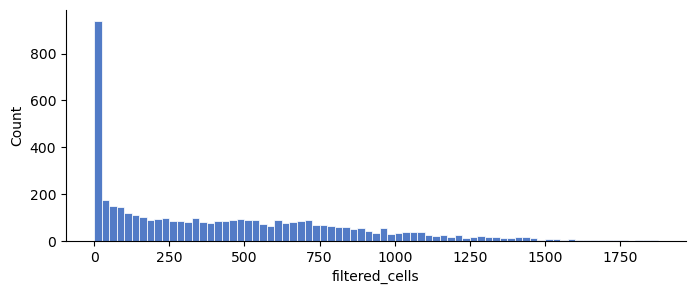

In [19]:
plt.figure(figsize=(8,3))
ax = sns.histplot(cell_counts_clones, binwidth=25, color="#527BC6", ec='white', alpha=1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [ ]:
ax.tick_params(axis='x', labelsize=5)  # Adjust x-axis tick label size
ax.tick_params(axis='y', labelsize=5)
plt.xlabel("compound index", fontsize=7)
plt.ylabel('Nuclear fluorescence intensity\n'+r'log2FC versus DMSO', fontsize=7)
#plt.ylabel("Nuclear fluorescence intensity\nlog_2(FC)", fontsize=7)
plt.ylim(-2,2)
plt.title("BRD4", fontsize=7)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=5, frameon=False, markerscale=0.4)
plt.savefig(savepath, bbox_inches="tight")
plt.show()

### Save list of clones and indicate which are among the selected ones for the large classifier

In [62]:
cell_counts_all_clones = pd.read_csv(all_clones_with_additional_metadata_savepath).rename(columns={
    'experiment': 'experiment',
    'plate': 'plate',
    'well': 'well',
    'assigned_gene_GFP': 'protein_GFP',
    'assigned_gene_mScarlet': 'protein_mScarlet',
    'top1_guide_GFP': 'sgRNA_GFP',
    'top1_guide_mScarlet': 'sgRNA_mScarlet',
})

In [63]:
cols_keep = ['experiment','plate','well','protein_GFP','protein_mScarlet','sgRNA_GFP','sgRNA_mScarlet']

In [76]:
clones_nonredundant_interest = pd.read_csv(clones_nonredunant_selected_list_savepath)
annot2 = pd.read_excel("/nobackup/lab_kubicek/jreinis/2023-09-18_train_RF_as_many_clones_as_possible/annotation_original_submission/SupplementaryTable4_AR_JR_20230714.xlsx")

In [77]:
clones_nonredundant_interest["well"] = get_well_ID(clones_nonredundant_interest)

In [78]:
cell_counts_all_clones.columns

Index(['#', 'experiment', 'plate', 'well', 'row', 'column', 'protein_GFP',
       'protein_mScarlet', 'top1_gene_GFP', 'top2_gene_GFP', 'top1_count_GFP',
       'top2_count_GFP', 'sgRNA_GFP', 'top2_guide_GFP', 'reads_sum_GFP',
       'guides_with_reads_GFP', 'has_assigned_gene_GFP', 'top1_gene_mScarlet',
       'top2_gene_mScarlet', 'top1_count_mScarlet', 'top2_count_mScarlet',
       'sgRNA_mScarlet', 'top2_guide_mScarlet', 'reads_sum_mScarlet',
       'guides_with_reads_mScarlet', 'has_assigned_gene_mScarlet',
       'plate_name', 'measurement', 'FOV', 'nfov', 'filtered_cells'],
      dtype='object')

In [79]:
all_clones_with_cell_counts = cell_counts_all_clones[cols_keep].drop_duplicates().merge(cell_counts_all_clones.groupby(cols_keep)["filtered_cells"].sum().reset_index(), how="left")
all_clones_with_cell_counts["filtered_cells"] = all_clones_with_cell_counts["filtered_cells"].fillna(0).astype("int")

In [117]:
to_export = all_clones_with_cell_counts[(all_clones_with_cell_counts.protein_GFP.notnull()) | (all_clones_with_cell_counts.protein_mScarlet.notnull())]
to_export = to_export.reset_index(drop=True).reset_index().rename(columns={"index":"#"})
to_export["#"] += 1
to_export = to_export.merge(clones_nonredundant_interest[["experiment", "plate", "well","filtered_cells", "clone_label"]], how="left")
to_export["in_set_of_1065_clones"] = to_export.clone_label.notna()
to_export["clone_label_set_of_1065_clones"] = to_export.clone_label.replace(np.nan,-1).astype("int").astype("str").str.replace("-1", "")
to_export = to_export[["#"] + cols_keep + ["filtered_cells", "in_set_of_1065_clones", "clone_label_set_of_1065_clones"]]
to_export.loc[to_export.protein_GFP.isna(),"sgRNA_GFP"] = np.nan
to_export.loc[to_export.protein_mScarlet.isna(),"sgRNA_mScarlet"] = np.nan

to_export.to_csv(savepath_supplement_table_all_clones_with_counts_and_meta, index=None)
to_export

,#,experiment,plate,well,protein_GFP,protein_mScarlet,sgRNA_GFP,sgRNA_mScarlet,filtered_cells,in_set_of_1065_clones,clone_label_set_of_1065_clones
0,1,HAP1_cancer,plate1,A01,CBFB,PPP2R1A,CBFB_Intron1_1,PPP2R1A_ENST00000322088_Intron14_Frame1_sgRNA01,3,False,
1,2,HAP1_cancer,plate1,A02,RFC1,RB1,RFC1_Intron7_1,RB1_ENST00000267163_Intron26_Frame1_sgRNA01,938,True,0
2,3,HAP1_cancer,plate1,A04,NaN,SMAD4,NaN,SMAD4_ENST00000398417_Intron8_Frame1_sgRNA01,0,False,
3,4,HAP1_cancer,plate1,A06,NaN,SPTAN1,NaN,SPTAN1_ENST00000630866_Intron17_Frame1_sgRNA01,0,False,
4,5,HAP1_cancer,plate1,A08,NaN,PTCH1,NaN,PTCH1_ENST00000331920_Intron2_Frame1_sgRNA01,0,False,
...,...,...,...,...,...,...,...,...,...,...,...
4577,4578,HEK_proteome,plate5,P19,SMARCA1,SH3GLB1,SMARCA1_ENST00000371121_Intron1_Frame0_sgRNA01,SH3GLB1_ENST00000616170_Intron2_Frame1_sgRNA02,988,True,1063
4578,4579,HEK_proteome,plate5,P20,NaN,PDAP1,NaN,PDAP1_ENST00000350498_Intron5_Frame1_sgRNA02,0,False,
4579,4580,HEK_proteome,plate5,P21,C9orf40,LSM7,C9orf40_ENST00000376854_Intron1_Frame0_sgRNA02,LSM7_ENST00000252622_Intron3_Frame1_sgRNA02,40,False,
4580,4581,HEK_proteome,plate5,P22,IWS1,AP1M1,IWS1_ENST00000295321_Intron5_Frame0_sgRNA01,AP1M1_ENST00000444449_Intron7_Frame1_sgRNA02,155,False,
